In [ ]:
import os
import numpy as np
import torch
import cv2
from skimage.metrics import structural_similarity as compare_ssim
from runpy import run_path
#for restomer
!pip install einops
!pip install hdf5storage
import hdf5storage
import pandas as pd 
import math
import os

In [ ]:
def load_model():
     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    parameters = {'inp_channels':1, 'out_channels':1, 'dim':48, 'num_blocks':[4,6,6,8], 'num_refinement_blocks':4, 'heads':[1,2,4,8], 'ffn_expansion_factor':2.66, 'bias':False, 'LayerNorm_type':'BiasFree', 'dual_pixel_task':False}
    load_arch = run_path('/content/drive/MyDrive/SRFP/Restormer/basicsr/models/archs/restormer_arch.py')      #os.path.join('models', 'restormer_arch.py'))
    model = load_arch['Restormer'](**parameters)
    checkpoint = torch.load('/content/drive/MyDrive/SRFP/DPIR/model_zoo/gaussian_gray_denoising_sigma50.pth') #('/content/drive/MyDrive/SRFP/DPIR/model_zoo/gaussian_gray_denoising_sigma15.pth') # #torch.load('/content/drive/MyDrive/SRFP/DPIR/model_zoo/gaussian_color_denoising_blind.pth')
    model.load_state_dict(checkpoint['params'], strict=True)
    #model.load_state_dict(torch.load(model_path), strict=True) #load the weights of the network
    model.eval()# set to training mode
    for k, v in model.named_parameters():

        v.requires_grad = False
    model = model.to(device)
    return model    

In [ ]:
def proj(im_input, minval, maxval):  #proj(im_noisy, 0, 1)
    im_out = np.where(im_input > maxval, maxval, im_input)
    im_out = np.where(im_out < minval, minval, im_out)
    return im_out

def psnr(x,y):
    norm2 = np.mean((x - y) ** 2)
    psnrval = -10 * np.log10(norm2)
    return psnrval

def proxrhof(y, filtfft, rho, xhat):    #proxrhof(y, filtfft, rho, v-u)
    vf = np.fft.fft2(y + rho*xhat)
    x = np.real(np.fft.ifft2(np.divide(vf, filtfft + rho)))
    return x

def calculate_psnr(img1, img2):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))


In [ ]:
import time
def pnp_admm_deblur(model, im_input, im_ref, mask, **opts): # (model, im_noisy, im_orig, mask, **opts)
    max_list = []
    check_list = []
    rho = opts.get('rho', 1.0)
    maxitr = opts.get('maxitr', 100)
    verbose = opts.get('verbose',1)

    """ Initialization. """
    m, n = im_input.shape # m,n,c for 3 channels 
    index = np.nonzero(mask)                                                   
    w = len(mask[0])                                                            # w = 25 (mask shape is 25x25)
    r = int((w - 1) / 2)                                                        #r = 12
    im_orig = cv2.copyMakeBorder(im_input, r, r, r, r, borderType=cv2.BORDER_WRAP)#the noisy image
    y = cv2.filter2D(im_orig, -1, mask)                                         # *******applied kernel on the noisy image again
    y = y[r:r+m, r:r+n]
    im_input = im_input[r:r+m, r:r+m]                                           #*******made the image even smaller
    filtfft = np.square(np.absolute(np.fft.fft2(mask, y.shape)))

    x = 0.5 * np.ones((m,n), dtype=np.float64)
    v = np.copy(x)
    u = np.zeros((m,n), dtype=np.float64)
    
    """ Main loop. """
    for i in range(maxitr):

        xold = np.copy(x)
        vold = np.copy(v)
        uold = np.copy(u)
        """ Update variables. """

        x = proxrhof(y, filtfft, rho, v-u)
        """ Denoising step. """

        vtilde = np.copy(x+u)
        vtilde_torch = np.reshape(vtilde, (1,1,m,n))
        vtilde_torch = torch.from_numpy(vtilde_torch).type(torch.FloatTensor).cuda()
        r = model(vtilde_torch).cpu().numpy()
        r = np.reshape(r, (m,n))
        r = proj(r, -1., 1.) # was proj(r, -1., 1.)
        v = r # was 0.5*r + 0.5*vtilde

        """ Update variables. """
        u = uold + x - v


        """ Monitoring. """
        max_list.append(psnr(v, im_ref))
        index = max_list.index(np.max(max_list))
        if verbose:
            # print("i: ,{}, \t psnr: ,{},\t time: ,{}, "\
            #       .format(i+1, psnr(v, im_ref),time.time()))
            check_list.append((i+1,psnr(v, im_ref),time.time()))

    return v,np.max(max_list),index,check_list

In [ ]:
def iterate(input_array , rho_= 0.215, sigma_=67890 ,itr_ = 40):

  with torch.no_grad():
      im_orig = input_array     #im_orig1[:480,:320]
      m,n = im_orig.shape # m,n,c for colour image

      # ---- Replaced the kernel 
      kernel = cv2.getGaussianKernel(25, 1.6)
      mask = np.outer(kernel, kernel.transpose()) # outer product of two matrices; hense mask is the blur kernel

      #------to Add the kernel from the DPIR paper
      # kernels = hdf5storage.loadmat('/content/drive/MyDrive/SRFP/DPIR/kernels/Levin09.mat')['kernels']
      # k_index = 0   #there are totally 8 kernels 
      # mask = kernels[0, k_index].astype(np.float64)


      # ---- blur the image      
      w = len(mask[0])  # w = 25; the new kernal is a 17 x 17 kernel 
      r = int((w - 1) / 2) # r  = 12
      im_orig = cv2.copyMakeBorder(im_orig, r, r, r, r, borderType=cv2.BORDER_WRAP) # added 8 pixel border on all directions
      im_blur = cv2.filter2D(im_orig, -1, mask) #after applying the kernel 
      im_blur = im_blur[r:r+m, r:r+n]
      im_orig = im_orig[r:r+m, r:r+n]

      # ---- add noise -----
      noise_level =  7.65/255.0    #10.0 /255.0
      gauss = np.random.normal(0.0, noise_level, im_blur.shape)
      im_noisy = im_blur + gauss
      im_noisy = proj(im_noisy, 0, 1) # just clipping the gradient between 0 and 1 

      # ---- set options -----
      sigma = sigma_
      rho = rho_#1
      maxitr = itr_  # 30
        # maximum no of iterations 
      opts = dict(sigma=sigma, rho=rho, maxitr=maxitr, verbose=True)

      # ---- load the model ----
      model = load_model()

      # ---- plug and play -----
      out ,max, index ,check_list= pnp_admm_deblur(model, im_noisy, im_orig, mask, **opts)

      # ---- results ----
      psnr_ours = psnr(out, im_orig)
      ssim_ours = compare_ssim(out, im_orig, data_range=1.)
      print('sigma = {}, rho = {} - PNSR: {}, SSIM = {} Max : {}, Index : {}'.format(sigma, rho, psnr_ours, ssim_ours,max,index))
      return   (out , sigma, rho, psnr_ours, ssim_ours,max,index,check_list)



In [ ]:
def driver(rho_, itr_):
  temp = '/content/drive/MyDrive/SRFP/DPIR/testsets/set3c/starfish.png'
  im_orig = cv2.imread(temp)/255.0

  #------------------------- splitting each channel 
  im_orig_r = im_orig[:,:,0]
  im_orig_g = im_orig[:,:,1]
  im_orig_b = im_orig[:,:,2]

  #-------------------------Predicting each channel 
  sum = 0
  avg_psnr = 0 
  _rho_ = rho_
  _itr_ = itr_
  out_r , sigma, rho, psnr_ours, ssim_ours,max,index,check_list = iterate(im_orig_r,rho_ = _rho_, itr_ = _itr_) ; sum = sum + index  
  # avg_psnr = avg_psnr + max
  # out_g , sigma, rho, psnr_ours, ssim_ours,max,index = iterate(im_orig_g,rho_ = _rho_, itr_ = _itr_) ; sum = sum + index 
  # avg_psnr = avg_psnr + max
  # out_b , sigma, rho, psnr_ours, ssim_ours,max,index = iterate(im_orig_b,rho_ = _rho_, itr_ = _itr_) ; sum = sum + index  
  # avg_psnr = avg_psnr + max

  # print('give_itr',math.ceil(sum/3), 'with_iter_set ****',avg_psnr/3)

  #-------------------------Merginng all channels together
  im_recon = np.ones(im_orig.shape, out_r.dtype)
  im_recon[:,:,0] = np.uint8((out_r*255.0).round())
  im_recon[:,:,1] = np.uint8((out_r*255.0).round())
  im_recon[:,:,2] = np.uint8((out_r*255.0).round()) 
  im_recon = im_recon.astype('uint8')

  #-------------------------Psnr
  psnr = calculate_psnr(im_recon,cv2.imread(temp))
  print('current psnr',psnr)
  print(check_list)
  #cv2.imwrite('SASBlindrho'+str(rho_)+'itr'+str(itr_)+str(psnr) +'.png', im_recon)


In [ ]:
driver(rho_ = .07, itr_ = 9)


sigma = 67890, rho = 0.07 - PNSR: 25.89139593662555, SSIM = 0.7400182688675111 Max : 26.21462605693848, Index : 2
current psnr 11.522544255825249
[(1, 25.313166899791323, 1658942910.6318524), (2, 26.101836030124215, 1658942910.8307214), (3, 26.21462605693848, 1658942911.0258453), (4, 26.185836304280695, 1658942911.2208133), (5, 26.177927538993902, 1658942911.4155574), (6, 26.136201341043943, 1658942911.6104367), (7, 26.07425080594504, 1658942911.8052642), (8, 26.004956801014455, 1658942912.000187), (9, 25.89139593662555, 1658942912.1948578)]


In [ ]:
import pandas as pd
df = pd.DataFrame(l, columns =['iter', 'psnr', 'time'])


In [ ]:
df['time'] = df['time']- 1658942910.6318524

In [ ]:
df

,iter,psnr,time
0,1,25.313167,0.000000
1,2,26.101836,0.198869
2,3,26.214626,0.393993
3,4,26.185836,0.588961
4,5,26.177928,0.783705
5,6,26.136201,0.978584
6,7,26.074251,1.173412
7,8,26.004957,1.368335
8,9,25.891396,1.563005


In [ ]:
1.563005/9

0.17366722222222222

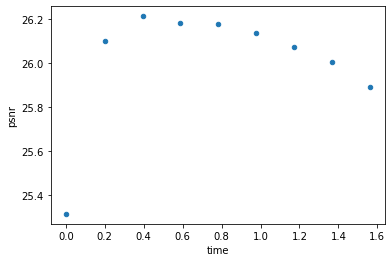

In [ ]:
df.plot(x = 'time',y ='psnr',kind='scatter' )

In [ ]:
df.describe()

,iter,psnr,time
count,9.000000,9.000000,9.000000
mean,5.000000,26.011133,0.783207
std,2.738613,0.280432,0.534436
min,1.000000,25.313167,0.000000
25%,3.000000,26.004957,0.393993
50%,5.000000,26.101836,0.783705
75%,7.000000,26.177928,1.173412
max,9.000000,26.214626,1.563005
